# Q6 - Foreground Histogram Equalization

In [99]:
import numpy as np, cv2 as cv, matplotlib.pyplot as plt
from pathlib import Path

DATA = Path("../data/a1images")
RESULTS = Path("../results/q6")
RESULTS.mkdir(parents=True, exist_ok=True)

img_path = DATA / "jeniffer.jpg"
img_bgr = cv.imread(str(img_path), cv.IMREAD_COLOR)
assert img_bgr is not None, f"Image not found at {img_path}"
print("Loaded:", img_path, "shape:", img_bgr.shape)

Loaded: ../data/a1images/jeniffer.jpg shape: (2160, 3840, 3)


In [100]:
# Split HSV and save planes
hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)
H, S, V = cv.split(hsv)
cv.imwrite(str(RESULTS/"q6_H.png"), H)
cv.imwrite(str(RESULTS/"q6_S.png"), S)
cv.imwrite(str(RESULTS/"q6_V.png"), V)

True

(np.float64(-0.5), np.float64(3839.5), np.float64(2159.5), np.float64(-0.5))

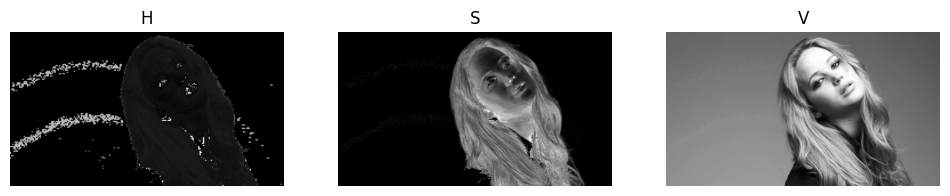

In [101]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(H, cmap='gray')
plt.title("H")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(S, cmap='gray')
plt.title("S")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(V, cmap='gray')
plt.title("V")
plt.axis('off')

In [102]:
# Select plane to threshold and extract binary foreground mask
# Start with S (often separates subject/background well). Use Otsu; invert if area is unreasonable.
plane_name, plane = "S", S
thr, mask = cv.threshold(plane, 15, 255, cv.THRESH_BINARY)

In [103]:
# Heuristic: ensure foreground isn’t almost everything or almost nothing
fg_ratio = (mask > 15).mean()
if fg_ratio > 0.90 or fg_ratio < 0.05:
    mask = cv.bitwise_and(mask)     # flip if Otsu picked the wrong polarity

# A tiny morphology to clean specks
k = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
mask = cv.morphologyEx(mask, cv.MORPH_OPEN, k, iterations=1)

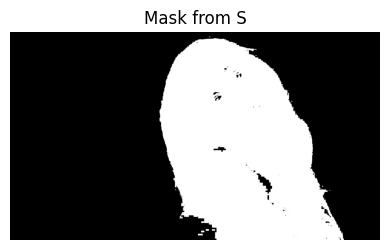

In [104]:
plt.figure(figsize=(4, 4))
plt.imshow(mask, cmap='gray')
plt.title(f"Mask from {plane_name}")
plt.axis('off')
plt.tight_layout()
plt.savefig(RESULTS/"q6_mask.png", dpi=150); plt.show()

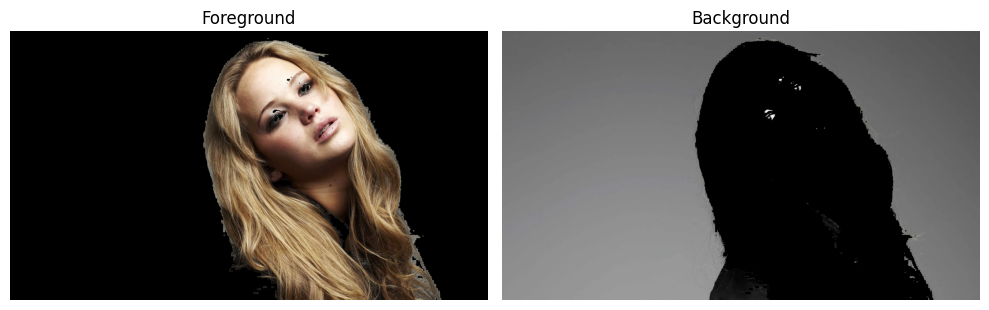

In [105]:
# Foreground via cv.bitwise_and and histogram on V using the mask
foreground_bgr = cv.bitwise_and(img_bgr, img_bgr, mask=mask)
background_bgr = cv.bitwise_and(img_bgr, img_bgr, mask=cv.bitwise_not(mask))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(foreground_bgr, cv.COLOR_BGR2RGB))
plt.title("Foreground")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(background_bgr, cv.COLOR_BGR2RGB))
plt.title("Background")
plt.axis('off')
plt.tight_layout()
plt.savefig(RESULTS/"q6_fg_bg.png", dpi=150)
plt.show()

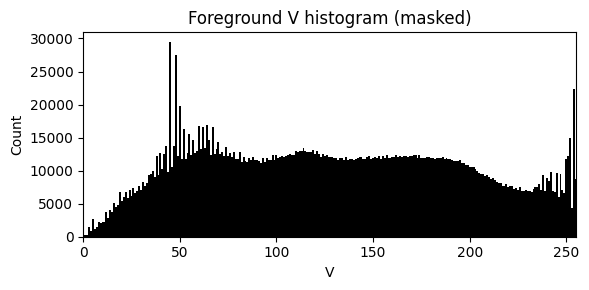

In [106]:
# Histogram of the Value (V) channel on foreground only
hist_fg = cv.calcHist([V], [0], mask, [256], [0, 256]).ravel().astype(np.float64)

plt.figure(figsize=(6, 3))
plt.bar(np.arange(256), hist_fg, width=1, color='black')
plt.title("Foreground V histogram (masked)")
plt.xlabel("V")
plt.ylabel("Count")
plt.xlim(0, 255)
plt.tight_layout()
plt.savefig(RESULTS/"q6_fg_hist_before.png", dpi=150)
plt.show()

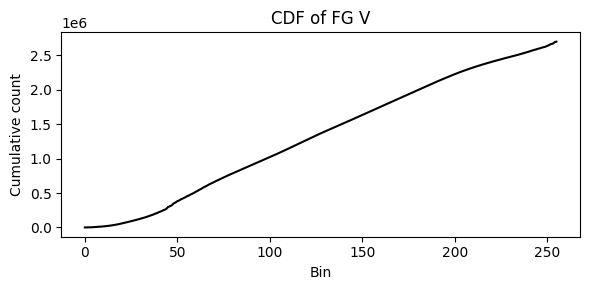

In [107]:
# Cumulative sum of the histogram
cdf_fg = np.cumsum(hist_fg)
pixels_fg = max(1.0, cdf_fg[-1])  # guard

plt.figure(figsize=(6, 3))
plt.plot(cdf_fg, color='black')
plt.title("CDF of FG V")
plt.xlabel("Bin")
plt.ylabel("Cumulative count")
plt.tight_layout()
plt.savefig(RESULTS/"q6_fg_cdf.png", dpi=150)
plt.show()

In [108]:
# Equalize the foreground using slide formulas
# Mapping: t(k) = round(255 * CDF_fg(k) / (#FG pixels))
t = np.floor(255.0 * (cdf_fg / pixels_fg) + 0.5).astype(np.uint8)

V_eq = V.copy()
fg = (mask > 0)
V_eq[fg] = t[V_eq[fg]]

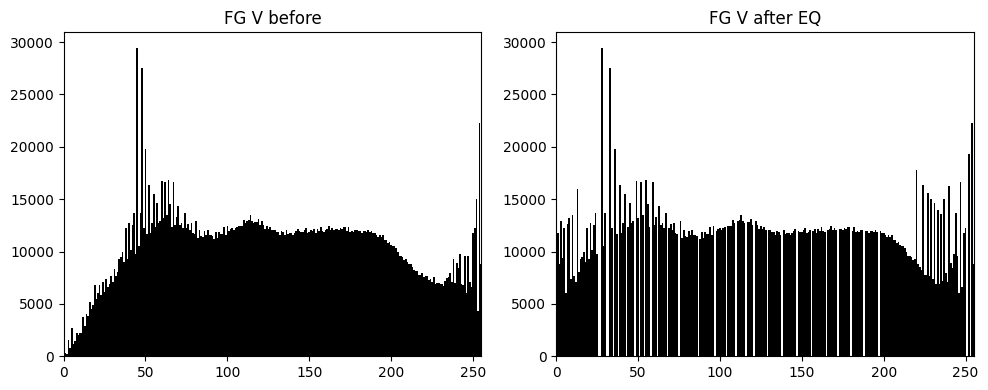

In [109]:
# For inspection: FG V histogram AFTER equalization
hist_fg_after = np.bincount(V_eq[fg].ravel(), minlength=256)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(np.arange(256), hist_fg,       width=1, color='black')
plt.title("FG V before")
plt.xlim(0, 255)
plt.subplot(1, 2, 2)
plt.bar(np.arange(256), hist_fg_after, width=1, color='black')
plt.title("FG V after EQ")
plt.xlim(0, 255)
plt.tight_layout()
plt.savefig(RESULTS/"q6_fg_hist_before_after.png", dpi=150)
plt.show()

In [110]:
# Recombine: extract background and ADD with FG-equalized foreground
# Build equalized color image (all pixels), then keep only the foreground part of it
hsv_eq_all = cv.merge([H, S, V_eq])
bgr_eq_all = cv.cvtColor(hsv_eq_all, cv.COLOR_HSV2BGR)
foreground_eq_bgr = cv.bitwise_and(bgr_eq_all, bgr_eq_all, mask=mask)

# Add foreground (equalized) to original background
result_bgr = cv.add(foreground_eq_bgr, background_bgr)

# Save and show
cv.imwrite(str(RESULTS/"q6_original.png"), img_bgr)
cv.imwrite(str(RESULTS/"q6_result_fg_eq.png"), result_bgr)

True

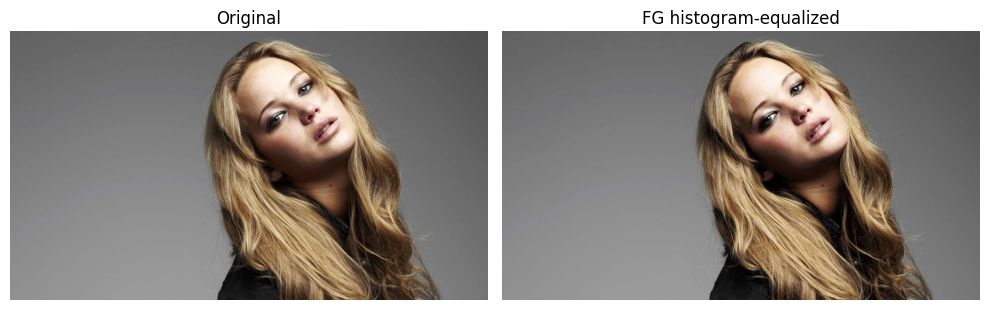

In [111]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(result_bgr, cv.COLOR_BGR2RGB))
plt.title("FG histogram-equalized")
plt.axis('off')
plt.tight_layout()
plt.savefig(RESULTS/"q6_before_after.png", dpi=150)
plt.show()